In [446]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [447]:
df = pd.read_csv("House_Rent_Dataset.csv")

In [448]:
df.shape

(4746, 12)

In [449]:
#Creat a wrangle function and prepare you data
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    #Subset data Unfurnished apartments with rent greater than 5000
    
    mask_status = df["Furnishing Status"] == "Unfurnished"
    mask_price = df["Rent"] > 5000
    df = df[mask_status & mask_price]
    
    # Subset data: Remove outliers for "Size"
    low, high = df["Size"].quantile([0.1, 0.9])
    mask_area = df["Size"].between(low, high)
    df = df[mask_area]
    
    #Drop low-high cardinallity feature variables
    df.drop(columns=["Posted On","Tenant Preferred","Point of Contact", "City","Furnishing Status","Floor","Bathroom"], inplace=True)
    return df
    

In [450]:
df = wrangle("House_Rent_Dataset.csv")
df.shape

(1377, 5)

In [451]:
df.head(10)

,BHK,Rent,Size,AreaType,AreaLocality
0,2,10000,1100,Super Area,Bandel
3,2,10000,800,Super Area,Dumdum Park
4,2,7500,850,Carpet Area,South Dum Dum
5,2,7000,600,Super Area,Thakurpukur
6,2,10000,700,Super Area,Malancha
8,2,26000,800,Carpet Area,"Palm Avenue Kolkata, Ballygunge"
13,1,5500,375,Carpet Area,Dum Dum Metro
14,3,8500,900,Carpet Area,Paschim Barisha
17,2,10000,800,Super Area,Behala
19,2,6000,660,Super Area,Behala


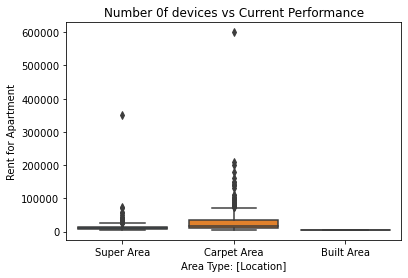

In [452]:
# Create boxplot

sns.boxplot(x="AreaType", y="Rent", data=df)

# Label axes
plt.xlabel("Area Type: [Location]")
plt.ylabel("Rent for Apartment")
plt.title("Number 0f devices vs Current Performance");

In [453]:
#Continued data Exploration using pivot
bed_rent_pivot =  pd.pivot_table(
     df, index = "BHK", values = "Rent" , aggfunc = np.mean  
).sort_values(by="Rent")
bed_rent_pivot.round(2)

,Rent
BHK,
1,13741.36
2,18923.74
5,22500.00
3,35716.12
4,74250.00


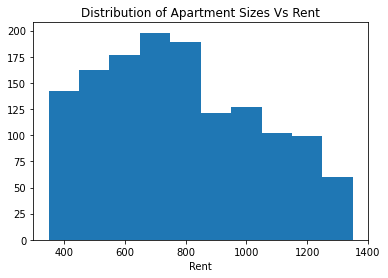

In [454]:
# Build histogram
plt.hist(df["Size"])
# Label axes
plt.xlabel("Rent")
# Add title
plt.title("Distribution of Apartment Sizes Vs Rent");

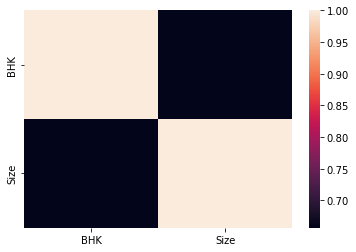

In [455]:
# select_dtypes is used to select numerical data
corr = df.select_dtypes("number").drop(columns="Rent").corr()
sns.heatmap(corr);

In [456]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "Rent"
features= ["AreaType","Size","BHK","AreaLocality"]
y_train = df[target]
X_train = df[features]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1377, 4)
y_train shape: (1377,)


In [457]:
#Calculate the baseline mean absolute error for your model.
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 19700.31
Baseline MAE: 13353.499644802649


In [458]:
#Instantiate OneHotEncoder
ohe = OneHotEncoder()

#Iterate your model
model = make_pipeline(
OneHotEncoder(use_cat_names=True),
SimpleImputer(),
Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['AreaType', 'AreaLocality'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [459]:
# Check your work
check_is_fitted(model[-1])

In [460]:
#MODEL EVALUATION
#CalculatING the training mean absolute error for your predictions as compared to the true targets in your y_train.

y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 6005.654243508775


In [461]:
#generating a list of predictions using your model.
X_test = df[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    12483.285698
1     9611.525194
2    17873.060243
3     7300.625693
4    13267.347217
dtype: float64

In [462]:
#A function that make predictions (syntax from WorldQuand University)
def make_prediction(AreaType, Size, BHK, AreaLocality):
    data = {
        "AreaType":AreaType,
        "Size":Size,
        "BHK":BHK,
        "AreaLocality": AreaLocality
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted Rent price: {prediction}"

In [463]:
make_prediction("Carpet Area",800, 1, "Paschim Barisha")

'Predicted Rent price: 6390.02'

In [465]:
   # Creating and interactive function
interact(
        make_prediction,
        AreaType=Dropdown(options=sorted(X_train["AreaType"].unique())
        ),
            Size=FloatSlider(
                min=X_train["Size"].min(),
                max=X_train["Size"].max(),
                step=0.01,
                value=X_train["Size"].mean(),
            ),
            BHK=FloatSlider(
                min=X_train["BHK"].min(),
                max=X_train["BHK"].max(),
                step=0.01,
                value=X_train["BHK"].mean(),
            ),
            AreaLocality=Dropdown(options=sorted(X_train["AreaLocality"].unique())),
     );

interactive(children=(Dropdown(description='AreaType', options=('Built Area', 'Carpet Area', 'Super Area'), va…